<a href="https://colab.research.google.com/github/hsuanchia/Image-caption/blob/main/imgcap_0427.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import json,re
from tensorflow.keras import backend as K
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.models import Model,load_model
from keras.layers import LSTM,TimeDistributed,Dense,Embedding,Input
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from PIL import Image 

In [ ]:
# Load Data
img_path = '/content/drive/MyDrive/MSCOCO_2017/val2017'
anno_path = '/content/drive/MyDrive/MSCOCO_2017/2017_annotations/captions_val2017.json'
input_file = open(anno_path)
annotation = json.load(input_file)

In [ ]:
def preprocess(text):
  text = text.lower()
  tmp = re.split('\W+',text)
  return tmp

In [ ]:
start= "sss"
end = "eee"

In [ ]:
max_length = 30
tmp = ""
sentence = []
for x in annotation['annotations']:
  tmp = preprocess(x['caption'])
  tmp = " ".join(tmp)
  x['caption'] = start + " " + tmp + " " + end
  sentence.append(x['caption'])
  #l = tmp.split()
  #if(len(l) > max_length):
 #     max_length = len(l)

# filters default without '<' '>' because <start> and <end>
token = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n',num_words=10000)
token.fit_on_texts(sentence)
word_index = token.word_index
inv_word_index = {v: k for k, v in word_index.items()}
#max_length += 2 #Plus '<start>','<end>'
voc_size = len(word_index) + 1

In [ ]:
print(annotation['annotations'][0])
print(annotation['images'][0])

{'image_id': 179765, 'id': 38, 'caption': 'sss a black honda motorcycle parked in front of a garage  eee'}
{'license': 4, 'file_name': '000000397133.jpg', 'coco_url': 'http://images.cocodataset.org/val2017/000000397133.jpg', 'height': 427, 'width': 640, 'date_captured': '2013-11-14 17:02:52', 'flickr_url': 'http://farm7.staticflickr.com/6116/6255196340_da26cf2c9e_z.jpg', 'id': 397133}


In [ ]:
def load_image(path, size=None):
  """
  Load the image from the given file-path and resize it
  to the given size if not None.
  """
  # Load the image using PIL.
  img = Image.open(path)

  # Resize image if desired.
  img = img.resize(size=(224,224), resample=Image.LANCZOS)

  # Convert image to numpy array.
  img = np.array(img)

  # Scale image-pixels so they fall between 0.0 and 1.0
  img = img / 255.0

  # Convert 2-dim gray-scale array to 3-dim RGB array.
  if (len(img.shape) == 2):
      img = np.repeat(img[:, :, np.newaxis], 3, axis=2)
  return img

In [ ]:
image_model = VGG16(include_top=True,weights='imagenet')
image_model.summary()

553467904/553467096 [==============================] - 6s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [ ]:
img_size = K.int_shape(image_model.input)[1:3]
transfer_layer = image_model.get_layer('fc2')
encoder_model = Model(inputs=image_model.input,outputs=transfer_layer.output)
value_size = K.int_shape(transfer_layer.output)[1]

In [ ]:
inputs1 = Input(shape=(4096,))
fe1 = Dense(256)(inputs1)

inputs2 = Input(shape=(max_length,voc_size))
#se1 = Embedding(voc_size, 256, mask_zero=False)(inputs2)
se2 = LSTM(256,return_sequences=True,return_state=False,name='LSTM1')(inputs2,initial_state=[fe1,fe1])
#se3 = Dense(voc_size)(se2)
decode1 = TimeDistributed(Dense(voc_size, activation='softmax'))(se2)

model = Model(inputs=[inputs1, inputs2], outputs=decode1)
# compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
# summarize model
model.summary()
#plot_model(model, to_file='model_1.png', show_shapes=True)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 4096)]       0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 30, 7181)]   0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 256)          1048832     input_4[0][0]                    
__________________________________________________________________________________________________
LSTM1 (LSTM)                    (None, 30, 256)      7616512     input_5[0][0]                    
                                                                 dense_2[0][0]              

In [ ]:
def data_generator(batch_num):
  x1, x2, y = list(), list(), list()
  n=0
  for cap in annotation['annotations']:
    n += 1
    tmp = ""
    for x in range(12-len((str)(cap['image_id']))):
      tmp += "0"
    tmp += (str)(cap['image_id']) + ".jpg"
    tmp_path = img_path + '/' + tmp  
    img = load_image(tmp_path)
    #print(img)
    image_batch = np.expand_dims(img, axis=0)
    photo = encoder_model.predict(image_batch,verbose=0) 
    seq = [word_index[word] for word in cap['caption'].split(' ') if word in word_index]
    in_seq = np.zeros((max_length,voc_size),dtype='float32')
    out_seq = np.zeros((max_length,voc_size),dtype='float32')
    #in_seq, out_seq = seq[:-1], seq[1:]
    '''
    in_seq = pad_sequences([in_seq],maxlen=max_length,padding='post')[0]
    out_seq = pad_sequences([out_seq],maxlen=max_length,padding='post')[0]
    out_seq = to_categorical([out_seq], num_classes=voc_size)[0]
    '''
    for i in range(0,len(seq)-1):
      tmp_in, tmp_out = seq[i], seq[i+1]
      in_seq[i,tmp_in] = 1
      out_seq[i,tmp_out] = 1
    
    #print(in_seq,out_seq)
    x1.append(photo[0])
    x2.append(in_seq)
    y.append(out_seq)
    print(n,'/',batch_num)
    if n == batch_num:
      #print([np.array(x1), np.array(x2)], np.array(y))
      return ([np.array(x1), np.array(x2)], np.array(y))

In [ ]:
trainx, trainy = data_generator(500)
#print(trainx)
#print(trainy)

1 / 500
2 / 500
3 / 500
4 / 500
5 / 500
6 / 500
7 / 500
8 / 500
9 / 500
10 / 500
11 / 500
12 / 500
13 / 500
14 / 500
15 / 500
16 / 500
17 / 500
18 / 500
19 / 500
20 / 500
21 / 500
22 / 500
23 / 500
24 / 500
25 / 500
26 / 500
27 / 500
28 / 500
29 / 500
30 / 500
31 / 500
32 / 500
33 / 500
34 / 500
35 / 500
36 / 500
37 / 500
38 / 500
39 / 500
40 / 500
41 / 500
42 / 500
43 / 500
44 / 500
45 / 500
46 / 500
47 / 500
48 / 500
49 / 500
50 / 500
51 / 500
52 / 500
53 / 500
54 / 500
55 / 500
56 / 500
57 / 500
58 / 500
59 / 500
60 / 500
61 / 500
62 / 500
63 / 500
64 / 500
65 / 500
66 / 500
67 / 500
68 / 500
69 / 500
70 / 500
71 / 500
72 / 500
73 / 500
74 / 500
75 / 500
76 / 500
77 / 500
78 / 500
79 / 500
80 / 500
81 / 500
82 / 500
83 / 500
84 / 500
85 / 500
86 / 500
87 / 500
88 / 500
89 / 500
90 / 500
91 / 500
92 / 500
93 / 500
94 / 500
95 / 500
96 / 500
97 / 500
98 / 500
99 / 500
100 / 500
101 / 500
102 / 500
103 / 500
104 / 500
105 / 500
106 / 500
107 / 500
108 / 500
109 / 500
110 / 500
111 / 50

In [ ]:
model.fit(trainx,trainy,epochs=100)

Epoch 1/100
16/16 [==============================] - 26s 1s/step - loss: 3.0305 - categorical_accuracy: 0.0439
Epoch 2/100
16/16 [==============================] - 22s 1s/step - loss: 1.9709 - categorical_accuracy: 0.0582
Epoch 3/100
16/16 [==============================] - 22s 1s/step - loss: 1.8848 - categorical_accuracy: 0.0789
Epoch 4/100
16/16 [==============================] - 22s 1s/step - loss: 1.8661 - categorical_accuracy: 0.0763
Epoch 5/100
16/16 [==============================] - 22s 1s/step - loss: 1.8485 - categorical_accuracy: 0.0753
Epoch 6/100
16/16 [==============================] - 22s 1s/step - loss: 1.8656 - categorical_accuracy: 0.0782
Epoch 7/100
16/16 [==============================] - 22s 1s/step - loss: 1.8318 - categorical_accuracy: 0.0772
Epoch 8/100
16/16 [==============================] - 22s 1s/step - loss: 1.8344 - categorical_accuracy: 0.0779
Epoch 9/100
16/16 [==============================] - 22s 1s/step - loss: 1.8082 - categorical_accuracy: 0.0773
E

In [ ]:
model.save('/content/drive/MyDrive/MSCOCO_2017/model_noatt427_2.h5')

In [ ]:
def Generate_caption(img_path):
  decoder_model = load_model('/content/drive/MyDrive/MSCOCO_2017/model_noatt427_2.h5')
  img = load_image(img_path)

  image_batch = np.expand_dims(img, axis=0)

  img_data = encoder_model.predict(image_batch,verbose=0)
  decoder_input = np.zeros((1,max_length,voc_size),dtype='float32')
  token_cur = word_index[start]
  output_text = ''
  count_tokens = 0
  while token_cur != word_index[end] and count_tokens < max_length:
    decoder_input[0,count_tokens,token_cur] = 1
    #print(decoder_input)
    decoder_output = decoder_model.predict([img_data,decoder_input])
    #print(decoder_output)
    '''
    seq = ''
    for i in decoder_output[0]:
      cur = np.argmax(i)
      if(cur != 0):
        seq += " " + inv_word_index[cur]
    print(seq)
    '''
    token_cur = np.argmax(decoder_output[0,count_tokens]) 
    #print(token_cur)
    cur_word = inv_word_index[token_cur]
    if(cur_word != end):
      output_text += " " + cur_word
    count_tokens += 1
  test_image = plt.imread(img_path)
  plt.imshow(test_image)
  plt.show()
  print("Caption:")
  print(output_text)

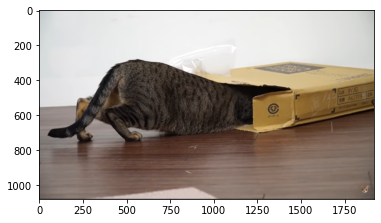

Caption:
 a person sitting on the middle of a bathroom


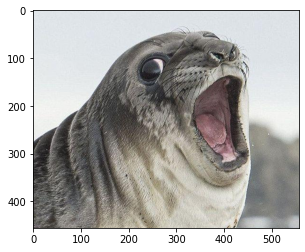

Caption:
 a cat eating a bird on a plate


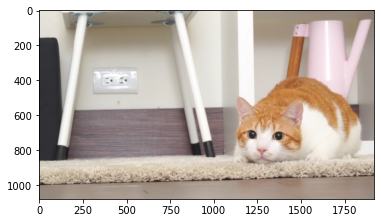

Caption:
 a bathroom with a sink and a sink and a shower


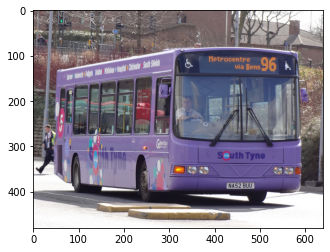

Caption:
 a black and white car in the street


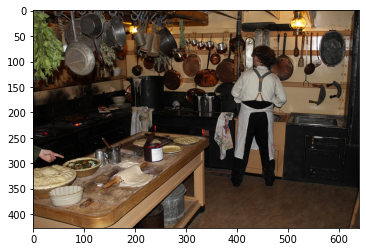

Caption:
 a person sitting in a woman in a bathroom


In [ ]:
Generate_caption('/content/drive/MyDrive/cat.png')
Generate_caption('/content/drive/MyDrive/seal.JPG')
Generate_caption('/content/drive/MyDrive/eggroll.jpg')
Generate_caption('/content/drive/MyDrive/MSCOCO_2017/val2017/000000002006.jpg')
Generate_caption('/content/drive/MyDrive/MSCOCO_2017/val2017/000000397133.jpg')

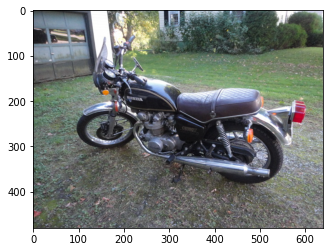

Caption:
 a motorcycle is parked in a motorcycle with a


In [ ]:
Generate_caption('/content/drive/MyDrive/MSCOCO_2017/val2017/000000179765.jpg')